<a href="https://colab.research.google.com/github/ekrell/ams_ai_shortcourse_2025/blob/main/AMSAI2025_DataBalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AMS AI Short Course: Data Balancing

**AMS AI Short Course**

The Colab Notebook demonstrates techniques that are very commonly proposed as solutions for learning with highly imbalanced datasets. We also point out criticisms that have been levied toward these methods. Here, we use 3 datasets and 2 modeling methods to investigate.

**Code sources**
- [Methods for Dealing with Imbalanced Data](https://www.kaggle.com/code/tboyle10/methods-for-dealing-with-imbalanced-data/notebook)
- [Working with highly imbalanced data](https://amueller.github.io/aml/05-advanced-topics/11-imbalanced-datasets.html)

# Introduction: Imbalanced Dataset Problem



**Why is it a problem?**
1. Not enough information to separate the classes
2. Trivial to optimize for the majority class (near-perfect performance to always guess "no storm")


**Is it always a problem?**

- With appropriate optimization criteria, correct classification of the minority class will improve performance, pushing the model to learn
- If the classes are separable given the training data, then today's modeling method should be robust to the class imbalance






In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, precision_recall_curve, roc_curve

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Modeling Method

- [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [ ]:
model_method = "RF"   # choices: 'LR', 'RF'

# Dataset

Select a classification dataset:

1. [Mammography](https://www.bcsc-research.org/index.php/datasets/mammography_dataset)
2. [California Environmental Conditions](https://www.kaggle.com/datasets/chelseazaloumis/cimis-dataset-with-fire-target)

Each column is numeric predictor, except a "Class" column with the target (0 or 1)

In [ ]:
select_dataset = "mammography"    # 'mammography',  "california"

In [ ]:
if select_dataset == "mammography":
  from sklearn.datasets import fetch_openml
  data = fetch_openml('mammography', as_frame=True)
  df = data.data
  targets = data.target.to_numpy().astype(int)
  targets[targets == -1] = 0
  df["Class"] = targets

In [ ]:
# if select_dataset == "mammography":
if select_dataset == "california":
  from sklearn.datasets import fetch_openml
  data = fetch_openml('California-Environmental-Conditions-Dataset', as_frame=True)
  df = data.data
  targets = data.target.to_numpy().astype(int)
  # targets[targets == -1] = 0
  df["Class"] = targets

  df = df.drop(["Date", "Stn_Id", "Stn_Name", "CIMIS_Region"], axis=1)

  df = df.dropna()

In [ ]:
df

,attr1,attr2,attr3,attr4,attr5,attr6,Class
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,0
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,0
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,0
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,0
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,0
...,...,...,...,...,...,...,...
11178,-0.250012,-0.377300,-0.321142,1.269157,3.652984,1.092791,1
11179,0.281343,-0.417112,-0.366224,0.851010,2.789649,1.345700,1
11180,1.204988,1.763724,-0.501468,1.562408,6.489072,0.931294,1
11181,0.736644,-0.222474,-0.050653,1.509665,0.539269,1.315229,1


In [ ]:
print(df.Class.value_counts())

Class
0    10923
1      260
Name: count, dtype: int64


In [ ]:
def plot_class_distribution(y):
  fig, axs = plt.subplots(1, 2, figsize=(10, 3))
  axs[0].hist(y, bins=range(3), align='left', rwidth=0.8, color='blue', alpha=0.7)
  axs[0].set_xticks(range(2), ['Class 0', 'Class 1'])
  axs[0].set_title("Class Distribution")
  axs[0].set_ylabel("Number of Instances")

  axs[1].hist(y, bins=range(3), align='left', rwidth=0.8, color='blue', alpha=0.7)
  axs[1].set_xticks(range(2), ['Class 0', 'Class 1'])
  axs[1].set_yscale('log')
  axs[1].set_title("Log scale Class Distribution")

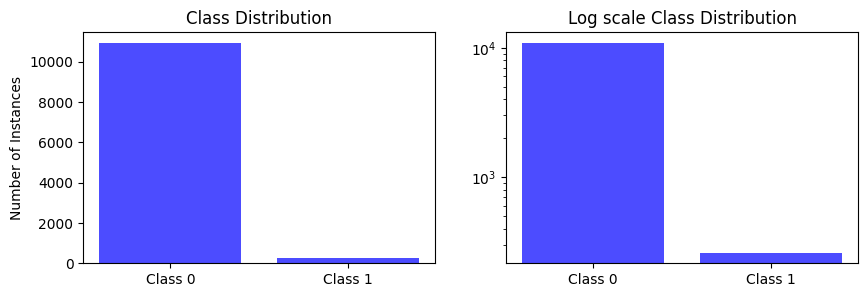

In [ ]:
plot_class_distribution(df["Class"])

In [ ]:
# Prepare data for modeling
# Separate input features and target
y = df.Class
X = df.drop('Class', axis=1)
# Setting up validing and training sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=27)

In [ ]:
def print_scores(scores):
  print('Accuracy: ', scores[0])
  print('Recall: ', scores[1])
  print('Precision: ', scores[2])
  print('F1 score: ', scores[3])

**Baseline: always predict majority class**

In [ ]:
# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_valid)
# Checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

scores = (accuracy_score(y_valid, dummy_pred),
          recall_score(y_valid, dummy_pred),
          precision_score(y_valid, dummy_pred),
          f1_score(y_valid, dummy_pred))

print_scores(scores)

Unique predicted labels:  [0]
Accuracy:  0.978898426323319
Recall:  0.0
Precision:  0.0
F1 score:  0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Because of the high imbalance, we can achieve high accuracy by simply always predicting the majority class. But, this obviously has no skill and is not at all useful.

This observation has prompted researchers to develop methods for strategically resampling the training dataset to reduce this imbalance.

**Baseline: train model with original dataset**

In [ ]:
def train_and_evaluate(X_train, y_train, X_valid, y_valid, model_method="RF"):

  if model_method == "LR":
    model = LogisticRegression(solver='liblinear').fit(X_train, y_train)
  elif model_method == "RF":
    model = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

  # predict on valid set
  pred = model.predict(X_valid)
  # Scores
  return (accuracy_score(y_valid, pred),
          recall_score(y_valid, pred),
          precision_score(y_valid, pred),
          f1_score(y_valid, pred))

In [ ]:
scores = train_and_evaluate(X_train, y_train, X_valid, y_valid, model_method)
print_scores(scores)

Accuracy:  0.9881974248927039
Recall:  0.4745762711864407
Precision:  0.9333333333333333
F1 score:  0.6292134831460674


The model has learned to correctly recognize at least some of the minority cases. Even with imbalance, the minority class appears to be capable of influencing the model.

### Metrics

- Different metrics highlights different model characteristics
- Will be disucssed in detail later, in the [model evaluation notebook](https://github.com/ekrell/ams_ai_shortcourse_2025/blob/main/AMSAI2025_Evaluation.ipynb)
- [Source](https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall)

**Accuracy**

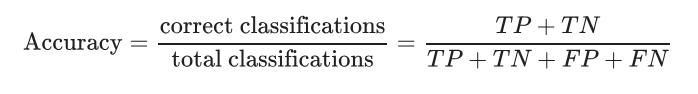

**Recall: True Positive Rate (AKA: _probability of detection_)**

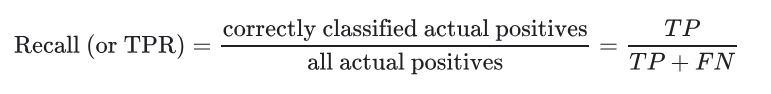



**Precision: proportion positive classifications that are actually positive**

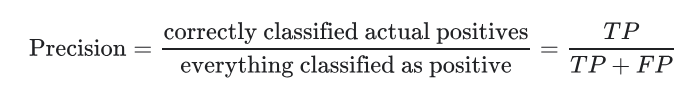

**F1 Score: harmonic mean of precision and recall**

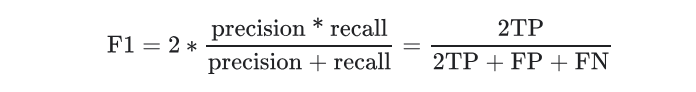

# Data Balancing Techniques

In [ ]:
props = np.linspace(0.0, 1.0, 5)[1:]
props

array([0.25, 0.5 , 0.75, 1.  ])

## Oversampling

Random Oversampling duplicates cases from the minority class.

By increasing the number of minority cases, we can limit the ability for the model to achieve high accuracy despite ignoring the minority class. The model optimization criteria is encouraged away from focusing only the correct classification of the majority.

**However:**

- No new information is presented to the model: the model is not going to become "more separable" than before.


**From the literature:**

> Random over-sampling, frequently considered an unprosperous method provided competitive results with the more complex methods.
- [Batista et al., 2004](https://dl.acm.org/doi/abs/10.1145/1007730.1007735)

> We noticed how oversampling perform better than undersampling for different classifiers and get higher scores in different evaluation metric
- [Mohammed et al., 2020](https://ieeexplore.ieee.org/abstract/document/9078901)

> we found that random oversampling or random undersampling towards different imbalance ratios generally does not improve the performance... we do not recommend"
- [Yang et al., 2023](file:///home/ekrell/Downloads/s40537-023-00857-7.pdf)

In [ ]:
scores_oversampling = np.zeros((len(props), 4))

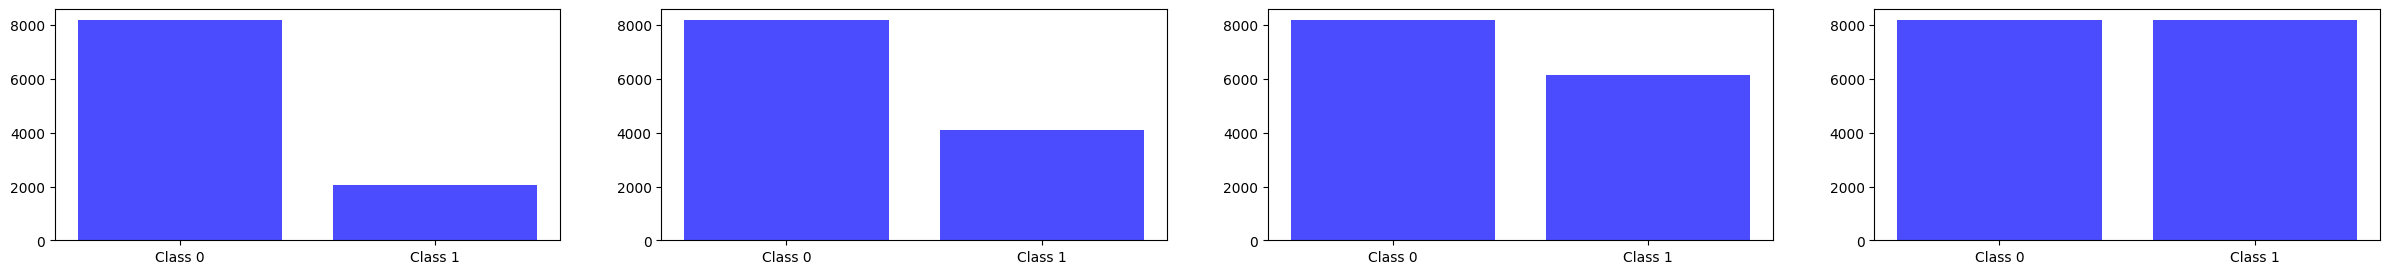

In [ ]:
fig, axs = plt.subplots(1, len(props), figsize=(30, 3));
for pi, prop in enumerate(props):
  oversampler = RandomOverSampler(sampling_strategy=prop, random_state=42)
  X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
  axs[pi].hist(y_resampled, bins=range(3), align='left', rwidth=0.8, color='blue', alpha=0.7)
  axs[pi].set_xticks(range(2), ['Class 0', 'Class 1'])
  scores_oversampling[pi] = train_and_evaluate(X_resampled, y_resampled, X_valid, y_valid, model_method)

In [ ]:
scores_oversampling

array([[0.98855508, 0.61016949, 0.8       , 0.69230769],
       [0.9860515 , 0.52542373, 0.73809524, 0.61386139],
       [0.98927039, 0.57627119, 0.87179487, 0.69387755],
       [0.98569385, 0.54237288, 0.71111111, 0.61538462]])

## Undersampling

Random Undersampling removes cases from the majority class.

This also reduces the imbalance such that the model is encouraged away from optimizing performance for the majority class.

**However:**

- You are throwing away information! Some of these cases may have provided a useful _contrast_ with the minority class, actually reducing class separability.

**From the literature:**

> we found that using under-sampling established a reasonable baseline for algorithmic comparison.
- [Drummond and Holt, 2003](http://www.eiti.uottawa.ca/~nat/Workshop2003/drummondc.pdf)

> well-known that undersampling one class modifies the priors of the training set and consequently biases the posterior probabilities of a classifier
- [Pozzolo et al., 2015](https://ieeexplore.ieee.org/abstract/document/7376606)

> partially undersampling... helps the performance, especially when there is not enough of the minority class... depends on the characteristics of the dataset, which requires more investigation.
- [Hasanin and Khoshgoftaar, 2018](https://ieeexplore.ieee.org/abstract/document/8424689)

In [ ]:
scores_undersampling = np.zeros((len(props), 4))

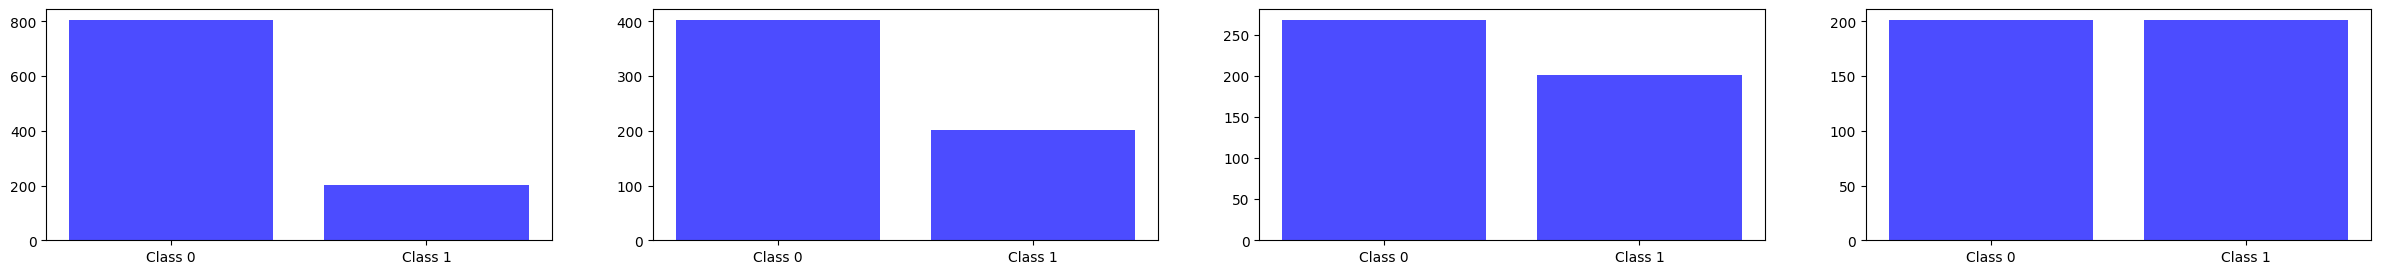

In [ ]:
fig, axs = plt.subplots(1, len(props), figsize=(30, 3));
for pi, prop in enumerate(props):
  undersampler = RandomUnderSampler(sampling_strategy=prop, random_state=42)
  X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)
  axs[pi].hist(y_resampled, bins=range(3), align='left', rwidth=0.8, color='blue', alpha=0.7)
  axs[pi].set_xticks(range(2), ['Class 0', 'Class 1'])
  scores_undersampling[pi] = train_and_evaluate(X_resampled, y_resampled, X_valid, y_valid, model_method)

In [ ]:
scores_undersampling

array([[0.972103  , 0.72881356, 0.40952381, 0.52439024],
       [0.96030043, 0.79661017, 0.32191781, 0.45853659],
       [0.94670959, 0.76271186, 0.25      , 0.37656904],
       [0.92918455, 0.86440678, 0.21161826, 0.34      ]])

## SMOTE

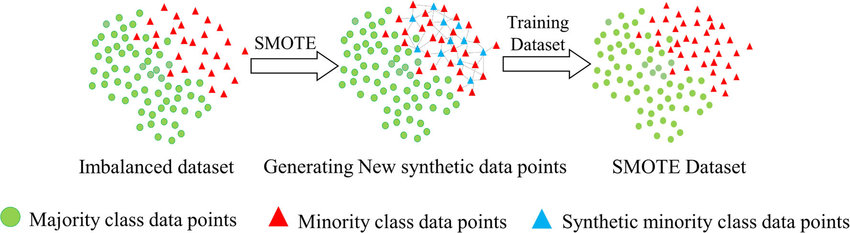

[Image source: Aldraimli et al.](https://www.researchgate.net/publication/343326638_Machine_learning_prediction_of_susceptibility_to_visceral_fat_associated_diseases)

Synthetic Minority Over-Sampling Technique (SMOTE) reduces dataset imbalance by adding **brand-new** cases of the minority class.

This technique uses the minority sample's feature values to produce new, synthetic samples. The idea is that it increases the number of minority class cases, but with new information for the model to learn from (unlike Random Oversampling).

**However:**

- These cases might not be realistic at all! They are just interpolation between the other cases, which may violate real-word constraints on possible combinations of the values.

- If you get lucky, you might generate samples that could exist in real-life, with patterns that are rich different enough from the original set of observations to provide valuable information for the training process.

**Which of these is most likely?**

**From the literature:**

> The authors tested SMOTE on a wide variety of datasets with different training sizes and degree of imbalance. It was observed that the larger and less specific decision regions of SMOTE resulted in this method outperforming oversampling by replacement.
- [Thabtah et al., 2020](https://www.sciencedirect.com/science/article/pii/S0020025519310497)

>  confirmed that good results can be achieved thanks to the SMOTE technique
- [Bach et al., 2019](https://www.sciencedirect.com/science/article/pii/S1877050919313456)

> ([Random Undersampling] and SMOTE) was used to adjust the class imbalance in the classification training phase at the dataset level, which in turn,amplified the IG in many input features...  resulting in biased predictions towards the minority class
- [Aldraimli et al., 2020](https://www.researchgate.net/publication/343326638_Machine_learning_prediction_of_susceptibility_to_visceral_fat_associated_diseases)


In [ ]:
scores_smote = np.zeros((len(props), 4))

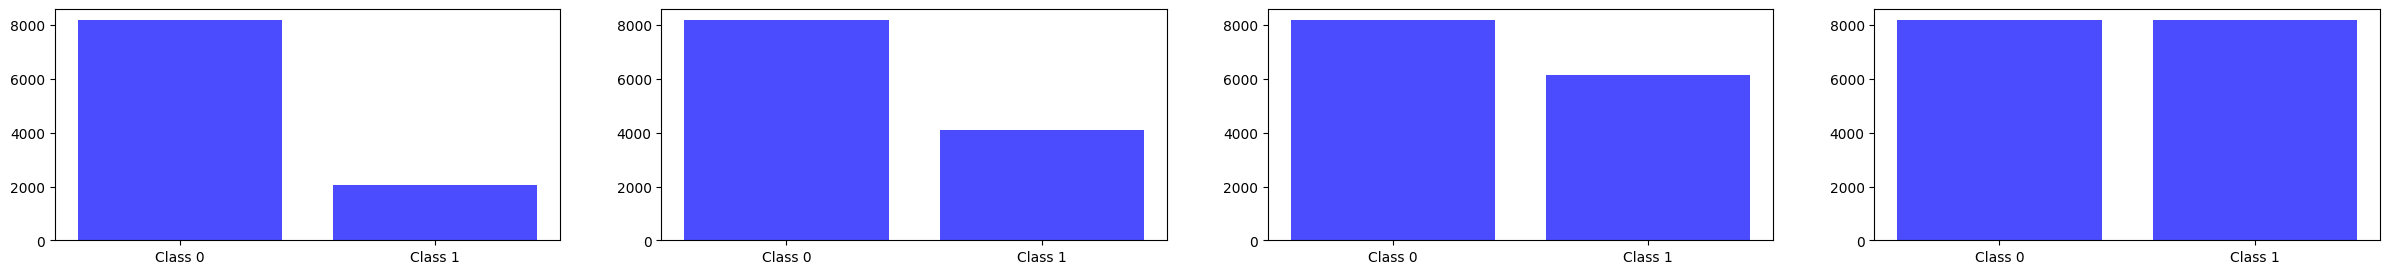

In [ ]:
fig, axs = plt.subplots(1, len(props), figsize=(30, 3));
for pi, prop in enumerate(props):
  smotesampler = SMOTE(sampling_strategy=prop, random_state=42)
  X_resampled, y_resampled = smotesampler.fit_resample(X_train, y_train)
  axs[pi].hist(y_resampled, bins=range(3), align='left', rwidth=0.8, color='blue', alpha=0.7)
  axs[pi].set_xticks(range(2), ['Class 0', 'Class 1'])
  scores_smote[pi] = train_and_evaluate(X_resampled, y_resampled, X_valid, y_valid, model_method)

In [ ]:
scores_smote

array([[0.98462089, 0.66101695, 0.62903226, 0.6446281 ],
       [0.98283262, 0.72881356, 0.57333333, 0.64179104],
       [0.98211731, 0.71186441, 0.56      , 0.62686567],
       [0.9767525 , 0.6779661 , 0.46511628, 0.55172414]])

# Weighted Optimization

Another approach:

- Problem: the majority case dominates the optimization criteria
- Even though the minority case is often what we are more interested in
- So: penalize wrong classification of the minority class more strongly

> assigning individual weights for each class instead of a single weight...  enhanced the overall performance of the classifier while producing high accuracy in identifying both majority and minority class
- [Zhu et al., 2018](https://ieeexplore.ieee.org/abstract/document/8246503)

> "can provide competitive solutions for hyperspectral image classification"
- [Jain and Phophalia, 2019](https://ieeexplore.ieee.org/abstract/document/8897862)

> this research found that the performance of the prediction model developed by [Weighted Random Forest] using the [imbalanced] dataset is still quite low
- [Effendy et al., 2014](https://ieeexplore.ieee.org/abstract/document/6914086)


> For imbalanced datasets, applying a weighted random forest is needed to improve performance for the sinkhole class. Higher weight for the sinkhole class resulted in higher rates in identifying true sinkholes, but it also resulted in more non-sinkholes misclassified as sinkhole
- [Zhu and Pierskalla Jr., 2016](https://www.sciencedirect.com/science/article/pii/S0022169415009518)

In [ ]:
weights = np.linspace(0.5, 1.0, 5)[1:]

weights

array([0.625, 0.75 , 0.875, 1.   ])

In [ ]:
scores_weights = np.zeros((len(props), 4))

In [ ]:
def train_and_evaluate(X_train, y_train, X_valid, y_valid, model_method="RF", weights=None):

  if model_method == "LR":
    model = LogisticRegression(solver='liblinear', class_weight=weights).fit(X_train, y_train)
  elif model_method == "RF":
    model = RandomForestClassifier(n_estimators=10, class_weight=weights).fit(X_train, y_train)

  # predict on valid set
  pred = model.predict(X_valid)
  # Scores
  return (accuracy_score(y_valid, pred),
          recall_score(y_valid, pred),
          precision_score(y_valid, pred),
          f1_score(y_valid, pred))

In [ ]:
for pi, weight in enumerate(weights):
  weight = {0:1-weight, 1:weight}
  print(f"Weights: class 0 = {weight[0]},  class 1 = {weight[1]}")
  scores_weights[pi] = train_and_evaluate(X_train, y_train, X_valid, y_valid, model_method, weight)

Weights: class 0 = 0.375,  class 1 = 0.625
Weights: class 0 = 0.25,  class 1 = 0.75
Weights: class 0 = 0.125,  class 1 = 0.875
Weights: class 0 = 0.0,  class 1 = 1.0


In [ ]:
scores_weights

array([[0.98891273, 0.52542373, 0.91176471, 0.66666667],
       [0.98783977, 0.47457627, 0.90322581, 0.62222222],
       [0.98783977, 0.49152542, 0.87878788, 0.63043478],
       [0.02110157, 1.        , 0.02110157, 0.041331  ]])

## Comparison

In [ ]:
metric_names = ["Accuracy", "Recall", "Precision", "F1"]

In [ ]:
props = np.concatenate((np.array([0]), props))

In [ ]:
scores_oversampling_ = np.vstack((np.array(scores).T, scores_oversampling))
scores_undersampling_ = np.vstack((np.array(scores).T, scores_undersampling))
scores_smote_ = np.vstack((np.array(scores).T, scores_smote))

In [ ]:
scores_weights_ = np.vstack((np.array(scores).T, scores_weights))

In [ ]:
scores_oversampling_[:,0]

array([0.98819742, 0.98855508, 0.9860515 , 0.98927039, 0.98569385])

In [ ]:
weights_ = np.concatenate((np.array([0]), weights))

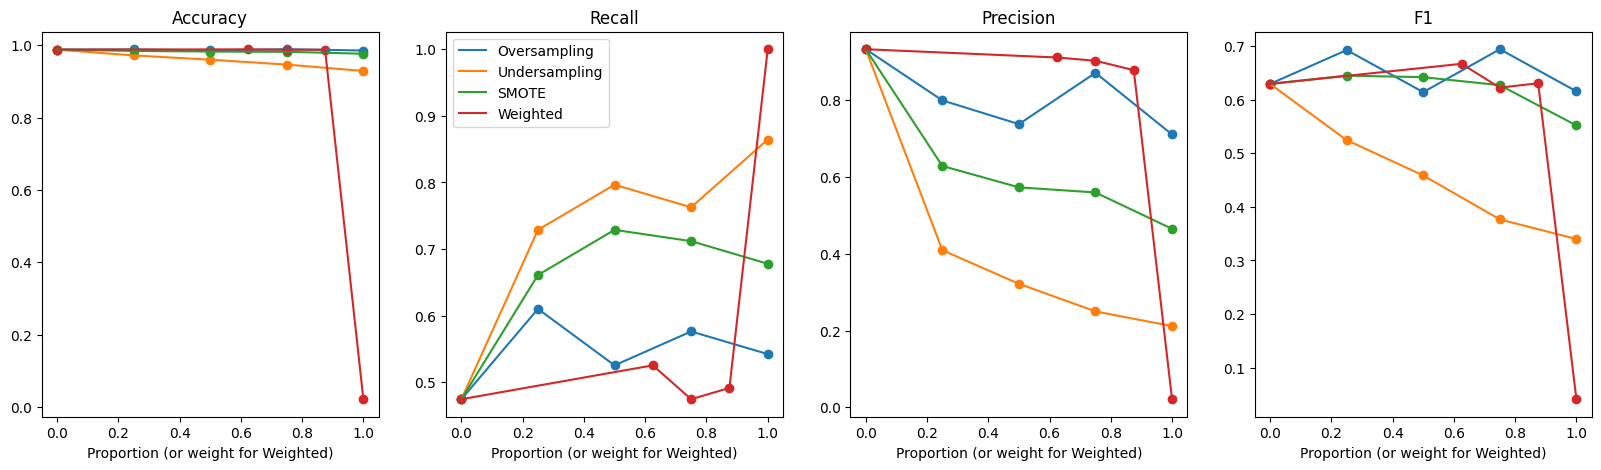

In [ ]:
n_runs, n_metrics = scores_oversampling_.shape

fig, axs = plt.subplots(1, n_metrics, figsize=(20, 5));

for i in range(n_metrics):
  axs[i].set_title(metric_names[i])
  axs[i].set_xlabel("Proportion (or weight for Weighted)")

  axs[i].plot(props, scores_oversampling_[:, i], label="Oversampling")
  axs[i].scatter(props, scores_oversampling_[:, i])

  axs[i].plot(props, scores_undersampling_[:, i], label="Undersampling")
  axs[i].scatter(props, scores_undersampling_[:, i])

  axs[i].plot(props, scores_smote_[:, i], label="SMOTE")
  axs[i].scatter(props, scores_smote_[:, i])

  axs[i].plot(weights_, scores_weights_[:, i], label="Weighted")
  axs[i].scatter(weights_, scores_weights_[:, i])

axs[1].legend()

# Bottom Line: these methods just shift metrics around

> We have empirically demonstrated that balancing is effective in shifting the focus of the classifiers towards the minority class resulting in better prediction of the minority samples and worse prediction of the majority samples. This correlated with better prediction performance for the weak classifiers but not for the strong ones.
- [To SMOTE, or not to SMOTE? - Elor and Averbuch-Elor, 2022](https://arxiv.org/abs/2201.08528)

> Resampling is used to alleviate the inflexibility of decision threshold (0.5 by default) but it renders interpretation of the values returned by `model.predict_proba` meaningless
- [Guillaume Lemaitre (author of `imbalanced-learn` library!)](https://www.youtube.com/watch?v=6YnhoCfArQo)

- But! Maybe that is okay! If we really want to not miss the minority class, we can sacrifice the majority class performance... and be okay with "meaningless" probabilities...

- But... **what if there is a simpler way that doesn't rely on these hacky methods?**

## Threshold Optimization

- The models we trained actually produce a value between 0 and 1
- When we calculate the metrics, the `predict` function is automacically converting it a binary decision using a threshold of 0.5
- But, we can select other thresholds!

In [ ]:
if model_method == "LR":
  model = LogisticRegression(solver='liblinear').fit(X_train, y_train)
elif model_method == "RF":
  model = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on valid set
pred = model.predict(X_valid)

In [ ]:
prob = model.predict_proba(X_valid)
prob_1 = prob[:,1]

In [ ]:
thresholds = np.linspace(0.0, 1.0, 21)[1:]
thresholds

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_valid, prob_1)
fpr, tpr, _ = roc_curve(y_valid, prob_1)

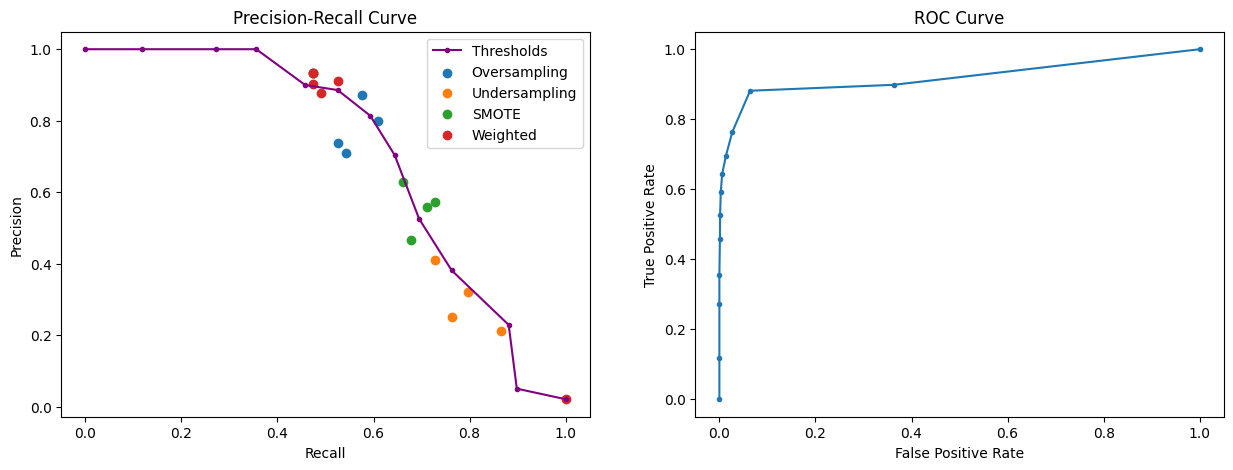

In [ ]:
#create precision recall curve
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(recall, precision, color='purple', marker='.', label="Thresholds")
axs[0].set_title('Precision-Recall Curve')
axs[0].set_ylabel('Precision')
axs[0].set_xlabel('Recall')

axs[1].plot(fpr, tpr, marker='.')
axs[1].set_title('ROC Curve')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_xlabel('False Positive Rate')


axs[0].scatter(scores_oversampling_[:,1], scores_oversampling_[:,2], label="Oversampling")
axs[0].scatter(scores_undersampling_[:,1], scores_undersampling_[:,2], label="Undersampling")
axs[0].scatter(scores_smote_[:,1], scores_smote_[:,2], label="SMOTE")
axs[0].scatter(scores_weights_[:,1], scores_weights_[:,2], label="Weighted")

axs[0].legend()